##   Facial Expression Recognition Using Transer Learning Version 1: MobileNet 


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Task 1: Import Libraries

In [1]:

from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
import scikitplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dropout, Dense, Flatten,GlobalMaxPool2D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
from keras.utils import plot_model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import model_from_json
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import math
import autoreload


In [ ]:
%load_ext autotime

### Task 2: Data Exploration & Plot Sample Images

In [2]:
os.listdir("./emotion_dataset/train/")

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

In [3]:
INPUT_PATH_TRAIN = "./emotion_dataset/train/"
total_images = 0
for dir in os.listdir(INPUT_PATH_TRAIN):
    count = len(os.listdir(INPUT_PATH_TRAIN + dir))
    total_images += count
    print(f"{dir} has {count} images")

print(f"total_images : {total_images}")

happy has 7214 images
sad has 4830 images
fear has 4097 images
surprise has 3171 images
neutral has 4965 images
angry has 3995 images
disgust has 436 images
total_images : 28708


In [10]:
INPUT_PATH_TEST = "./emotion_dataset/test/"
total_images_test = 0
for dir in os.listdir(INPUT_PATH_TEST):
    count = len(os.listdir(INPUT_PATH_TEST + dir))
    total_images_test += count
    print(f"{dir} has {count} images")

print(f"total_images_test : {total_images_test}")

disgust has 111 images
angry has 958 images
neutral has 1233 images
happy has 1774 images
sad has 1247 images
surprise has 831 images
fear has 1024 images
total_images_test : 7178
time: 25.2 s


In [5]:
TOP_EMOTIONS = ['fear', 'angry', 'happy', 'neutral', 'disgust', 'surprise', 'sad']
# total_images -= 380
# total_images
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH_TRAIN):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH_TRAIN + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH_TRAIN + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label



loaded all happy images to numpy arrays
loaded all sad images to numpy arrays
loaded all fear images to numpy arrays
loaded all surprise images to numpy arrays
loaded all neutral images to numpy arrays
loaded all angry images to numpy arrays
loaded all disgust images to numpy arrays


((28708, 48, 48, 3), array([0., 0., 0., ..., 6., 6., 6.]))

time: 6min 25s


In [7]:
label_to_text

{0: 'happy',
 1: 'sad',
 2: 'fear',
 3: 'surprise',
 4: 'neutral',
 5: 'angry',
 6: 'disgust'}

time: 3.93 ms


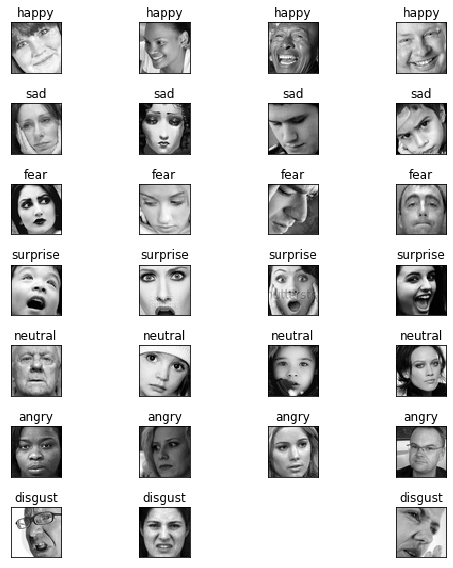

time: 4.42 s


In [10]:
fig = plt.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = plt.subplot(7,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        plt.tight_layout()

### Task 3: Generate Training and Validation Batches

In [11]:
img_arr.shape

(28708, 48, 48, 3)

time: 4.01 ms


In [12]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(28708, 7)

time: 207 ms


In [13]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25837, 48, 48, 3), (2871, 48, 48, 3), (25837, 7), (2871, 7))

time: 4.63 s


In [14]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]



time: 1.16 ms


### Task 4: Modelling

In [28]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

time: 1.98 s


In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 49, 49, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128 

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
# x = model.layers[-5].output
# global_pool = GlobalMaxPool2D(name="global_pool")(x)
# predictions = Dense(num_classes, activation="softmax")(global_pool)

# model = Model(inputs=model.input, outputs=predictions)


# x = model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x) 
# predictions = Dense(4, activation='softmax')(x)
# model = Model(model.input, predictions)

time: 38.2 ms


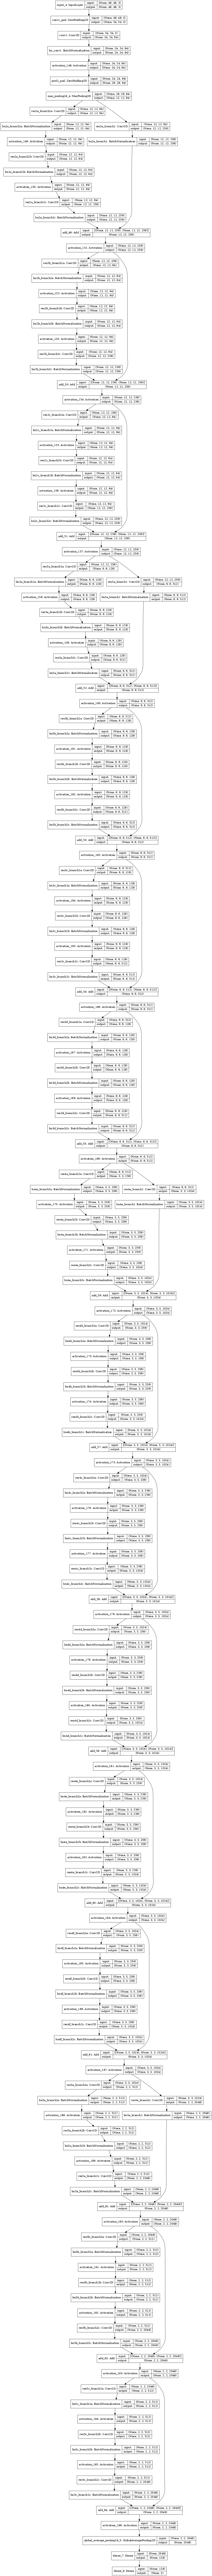

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, )

In [17]:
model.layers

time: 25.2 ms


In [30]:
for layer in model.layers[:15]:
    layer.trainable = False

time: 1.69 ms


In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

time: 3.4 s


In [32]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""



early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]


time: 2.04 ms


In [ ]:
# batch_size = 25
# epochs = 40
# opt = Adam(lr=0.001)

time: 6.52 ms


In [24]:
print(np.count_nonzero(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

0
False
time: 270 ms


In [26]:
from tensorflow.keras import optimizers


time: 691 µs


### Task 6: Train and Evaluate Model

In [33]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)
    



Epoch 1/40
1034/1033 [==============================] - 240s 232ms/step - loss: 1.7205 - accuracy: 0.3545 - val_loss: 1.4955 - val_accuracy: 0.4138 - lr: 0.0100
Epoch 2/40
1034/1033 [==============================] - 254s 246ms/step - loss: 1.4419 - accuracy: 0.4460 - val_loss: 1.3666 - val_accuracy: 0.4737 - lr: 0.0100
Epoch 3/40
1034/1033 [==============================] - 254s 246ms/step - loss: 1.3700 - accuracy: 0.4761 - val_loss: 1.3323 - val_accuracy: 0.4908 - lr: 0.0100
Epoch 4/40
1034/1033 [==============================] - 247s 238ms/step - loss: 1.3320 - accuracy: 0.4930 - val_loss: 1.3134 - val_accuracy: 0.5047 - lr: 0.0100
Epoch 5/40
1034/1033 [==============================] - 241s 233ms/step - loss: 1.3005 - accuracy: 0.5058 - val_loss: 1.4901 - val_accuracy: 0.4420 - lr: 0.0100
Epoch 6/40
1034/1033 [==============================] - 229s 221ms/step - loss: 1.2788 - accuracy: 0.5166 - val_loss: 1.2873 - val_accuracy: 0.5012 - lr: 0.0100
Epoch 7/40
1034/1033 [============

1034/1033 [==============================] - ETA: 0s - loss: 1.1440 - accuracy: 0.5713
Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
1034/1033 [==============================] - 240s 232ms/step - loss: 1.1440 - accuracy: 0.5713 - val_loss: 1.2536 - val_accuracy: 0.5395 - lr: 0.0100
Epoch 16/40
1034/1033 [==============================] - 222s 215ms/step - loss: 1.0835 - accuracy: 0.5967 - val_loss: 1.0674 - val_accuracy: 0.5928 - lr: 0.0025
Epoch 17/40
1034/1033 [==============================] - 247s 239ms/step - loss: 1.0624 - accuracy: 0.6019 - val_loss: 1.0684 - val_accuracy: 0.5907 - lr: 0.0025
Epoch 18/40
1034/1033 [==============================] - 241s 233ms/step - loss: 1.0594 - accuracy: 0.6036 - val_loss: 1.0656 - val_accuracy: 0.5967 - lr: 0.0025
Epoch 19/40
1034/1033 [==============================] - 243s 235ms/step - loss: 1.0428 - accuracy: 0.6101 - val_loss: 1.0373 - val_accuracy: 0.6015 - lr: 0.0025
Epoch 20/40
1034/1033 [============

1034/1033 [==============================] - 274s 265ms/step - loss: 0.9886 - accuracy: 0.6301 - val_loss: 1.0157 - val_accuracy: 0.6158 - lr: 0.0025
Epoch 30/40
1034/1033 [==============================] - 238s 230ms/step - loss: 0.9789 - accuracy: 0.6299 - val_loss: 1.0004 - val_accuracy: 0.6162 - lr: 0.0025
Epoch 31/40
1034/1033 [==============================] - ETA: 0s - loss: 0.9781 - accuracy: 0.6328
Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
1034/1033 [==============================] - 235s 227ms/step - loss: 0.9781 - accuracy: 0.6328 - val_loss: 1.0173 - val_accuracy: 0.6148 - lr: 0.0025
Epoch 32/40
1034/1033 [==============================] - 250s 241ms/step - loss: 0.9578 - accuracy: 0.6359 - val_loss: 0.9930 - val_accuracy: 0.6203 - lr: 6.2500e-04
Epoch 33/40
1034/1033 [==============================] - 232s 225ms/step - loss: 0.9522 - accuracy: 0.6422 - val_loss: 0.9843 - val_accuracy: 0.6249 - lr: 6.2500e-04
Epoch 34/40
1034/1033 [====

### Task 7: Represent Model as JSON String

In [ ]:

model_json = model.to_json()
with open("./model_MobileNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./model_MobileNet.h5")
print("Saved model to disk")


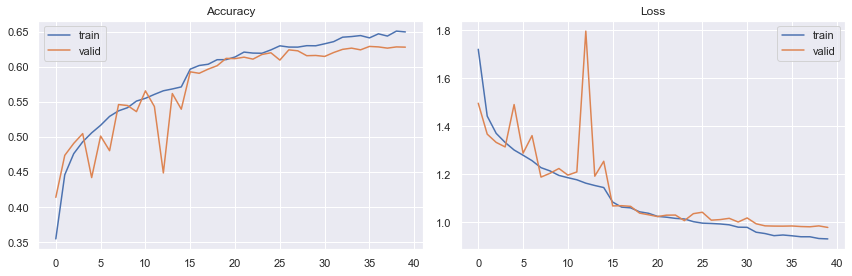

time: 1.87 s


In [34]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

#plt.savefig('epoch_history_resnet7-3-split.png')
plt.show()

test accuracy: 62.8004 %


              precision    recall  f1-score   support

           0       0.84      0.85      0.84       721
           1       0.52      0.53      0.52       483
           2       0.54      0.33      0.41       410
           3       0.72      0.73      0.73       317
           4       0.53      0.65      0.58       497
           5       0.52      0.56      0.54       399
           6       0.81      0.39      0.52        44

    accuracy                           0.63      2871
   macro avg       0.64      0.58      0.59      2871
weighted avg       0.63      0.63      0.62      2871



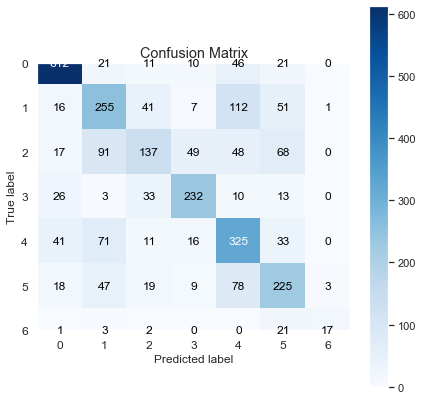

time: 7.75 s


In [36]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)
scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
#pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

[[612  21  11  10  46  21   0]
 [ 16 255  41   7 112  51   1]
 [ 17  91 137  49  48  68   0]
 [ 26   3  33 232  10  13   0]
 [ 41  71  11  16 325  33   0]
 [ 18  47  19   9  78 225   3]
 [  1   3   2   0   0  21  17]]


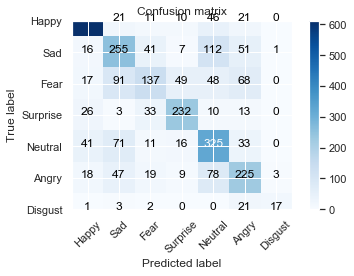

time: 563 ms


In [50]:
cm = confusion_matrix(ytest_, yhat_test)

labels = ['Happy','Sad','Fear','Surprise', 'Neutral','Angry', 'Disgust' ]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [40]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'happy': 0,
 'sad': 1,
 'fear': 2,
 'surprise': 3,
 'neutral': 4,
 'angry': 5,
 'disgust': 6}

time: 25.6 ms


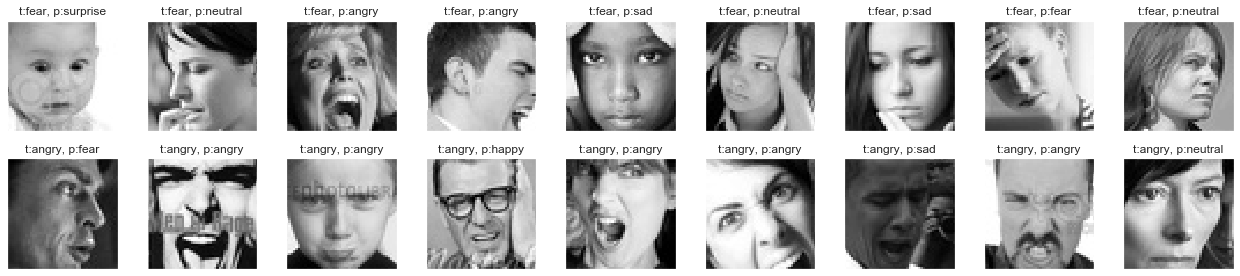

time: 2.62 s


In [42]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["angry"]]==1)[0], size=9, replace=False)

fig = plt.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        plt.tight_layout()


### Task 8: Analysis on Misclassified Images

In [46]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = plt.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

time: 4.39 ms


In [ ]:
0: 'happy',
 1: 'sad',
 2: 'fear',
 3: 'surprise',
 4: 'neutral',
 5: 'angry',
 6: 'disgust'

total 109 miss labels out of 721 for emotion happy


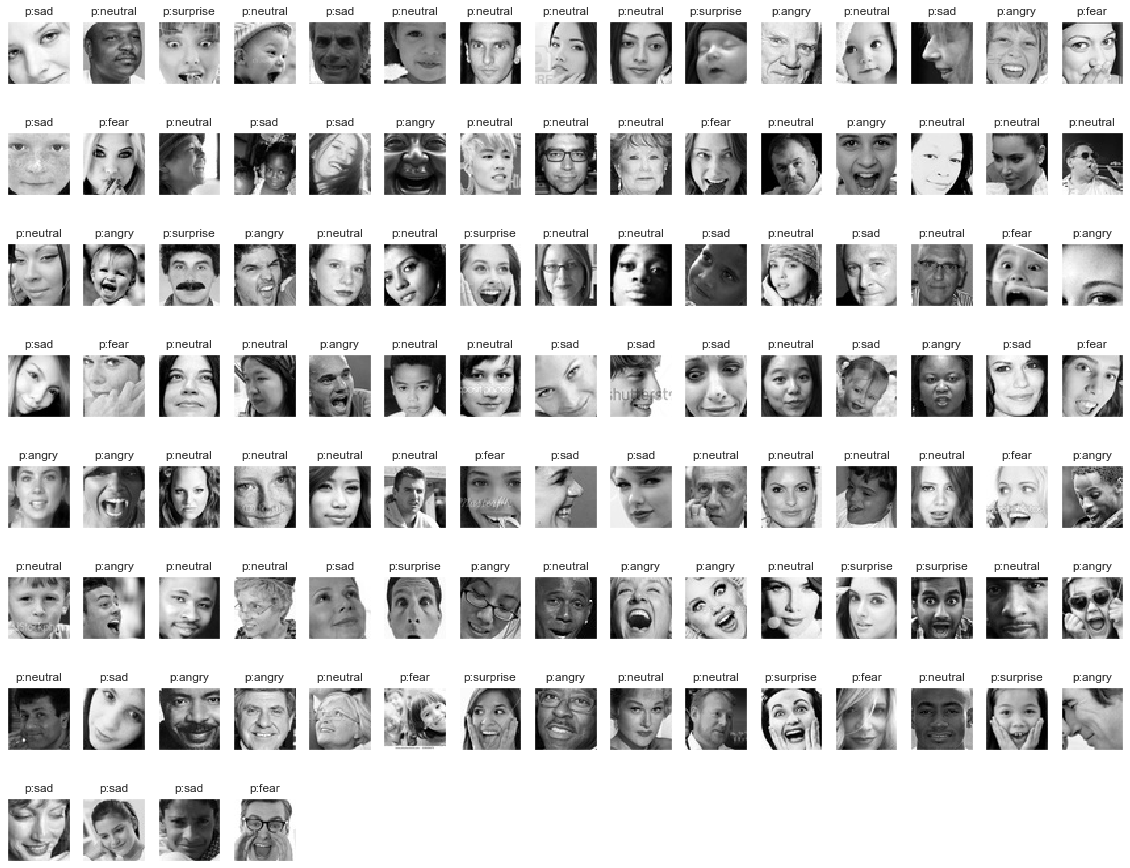

time: 10.1 s


In [47]:
plot_miss_classified(emotion="happy")

total 228 miss labels out of 483 for emotion sad


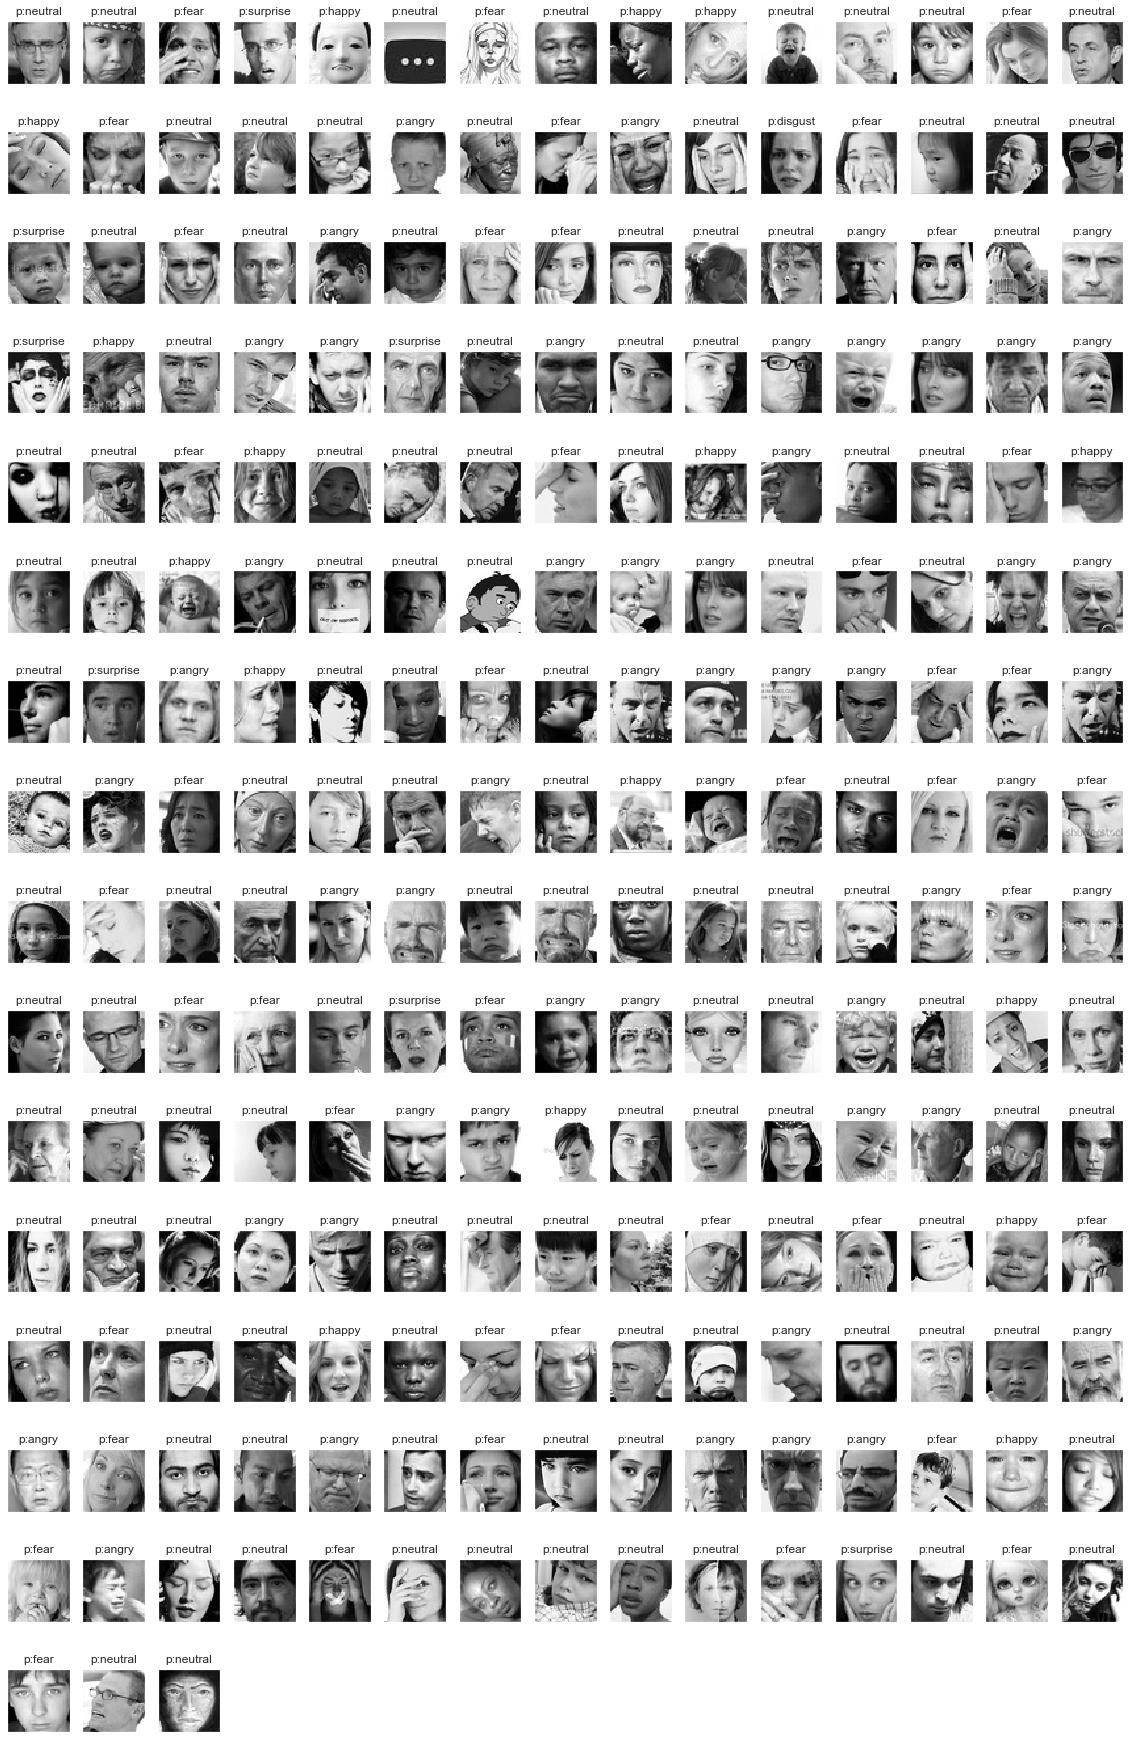

time: 22.1 s


In [48]:
plot_miss_classified(emotion="sad")

total 273 miss labels out of 410 for emotion fear


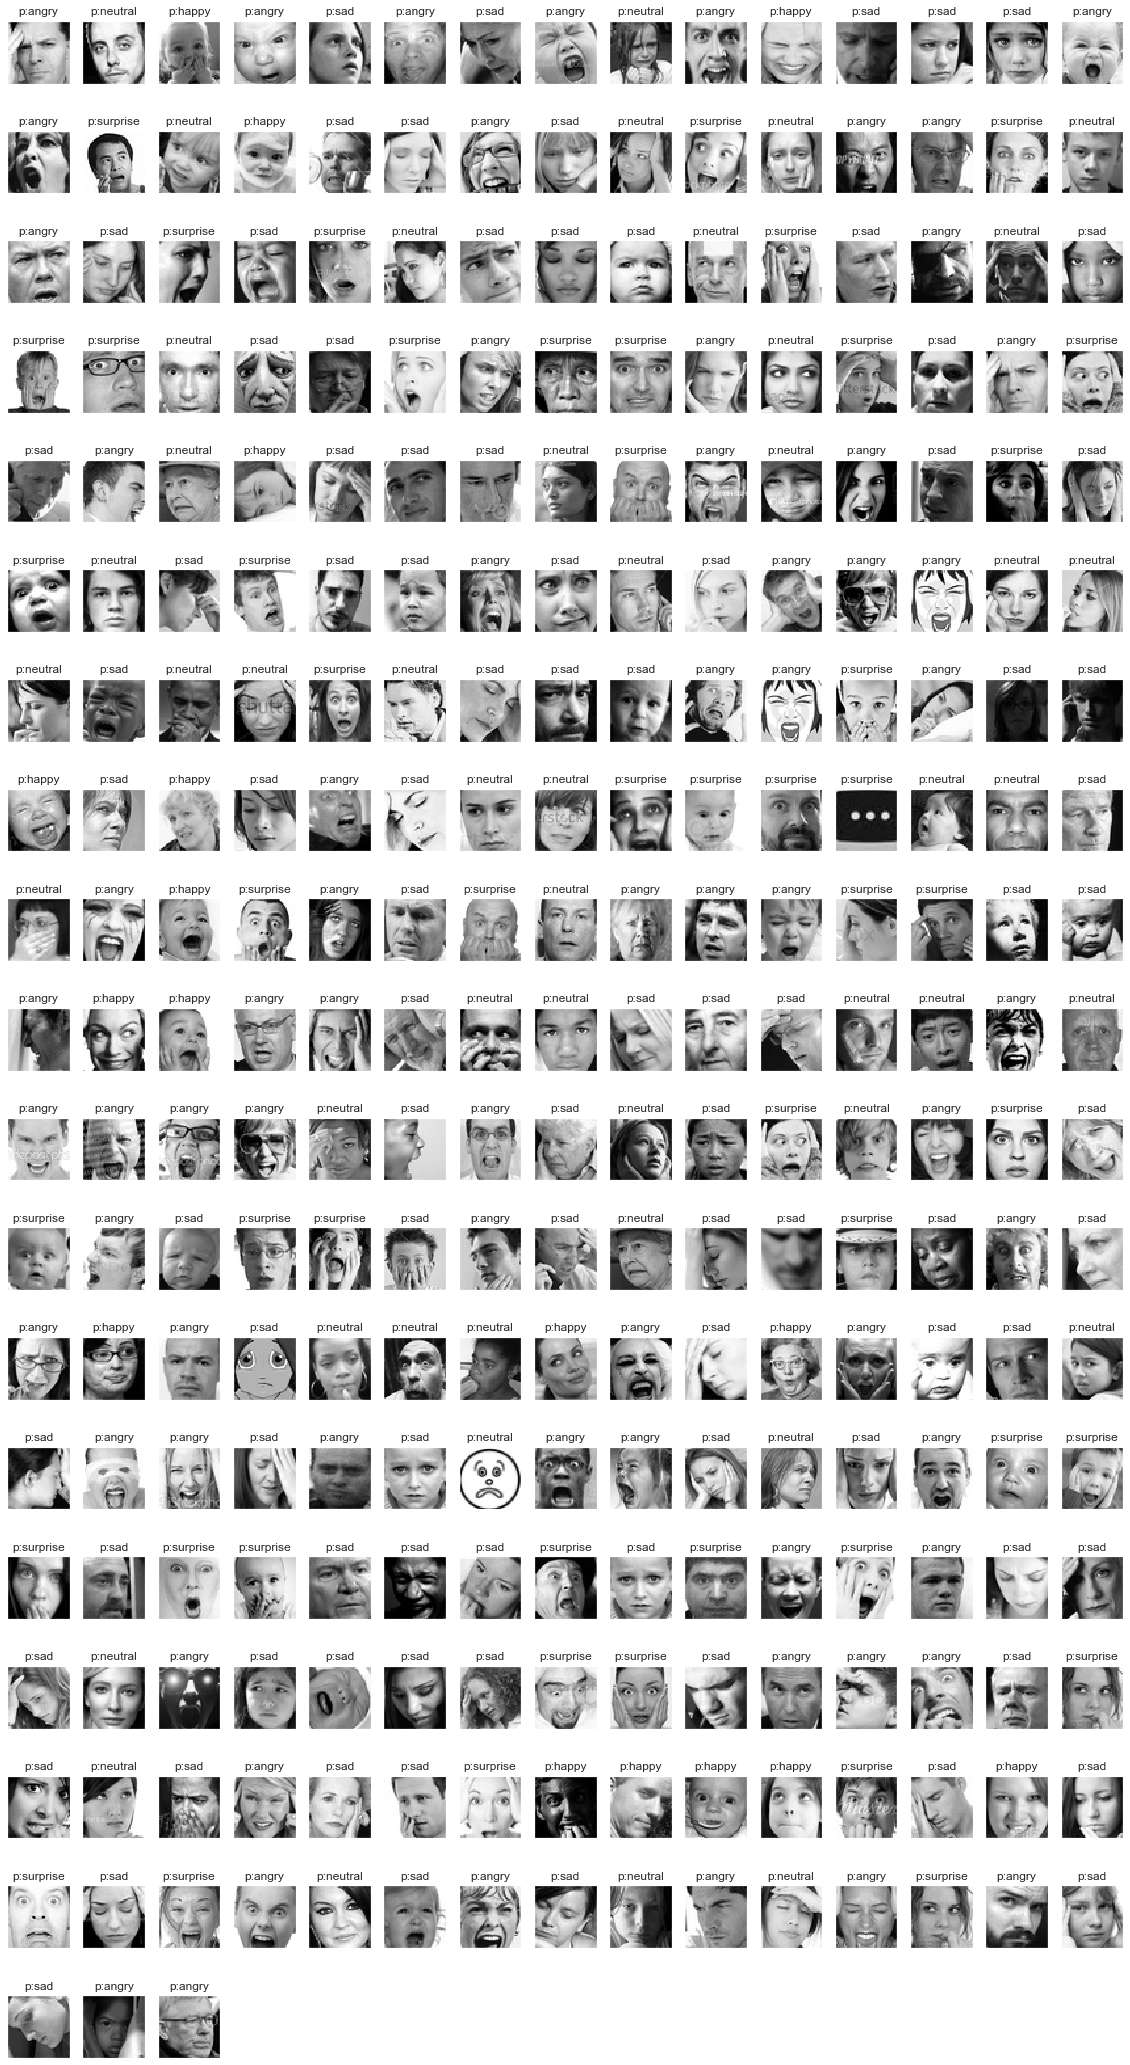

time: 30.4 s


In [49]:
plot_miss_classified(emotion="fear")

total 85 miss labels out of 317 for emotion surprise


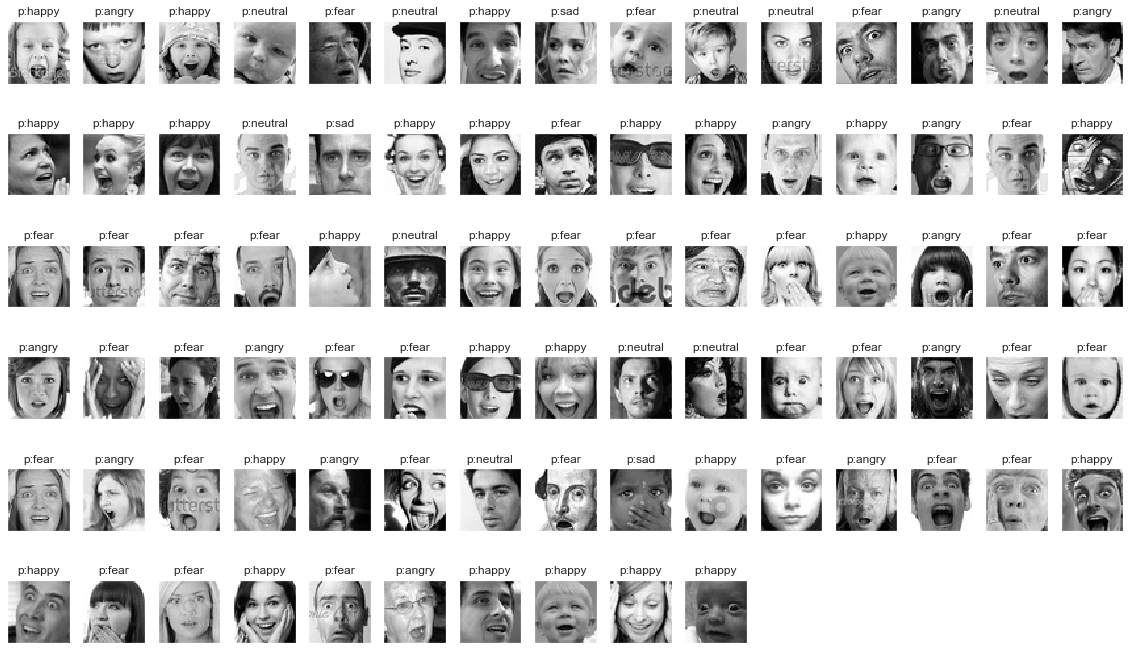

time: 7.3 s


In [51]:
plot_miss_classified(emotion="surprise")

total 172 miss labels out of 497 for emotion neutral


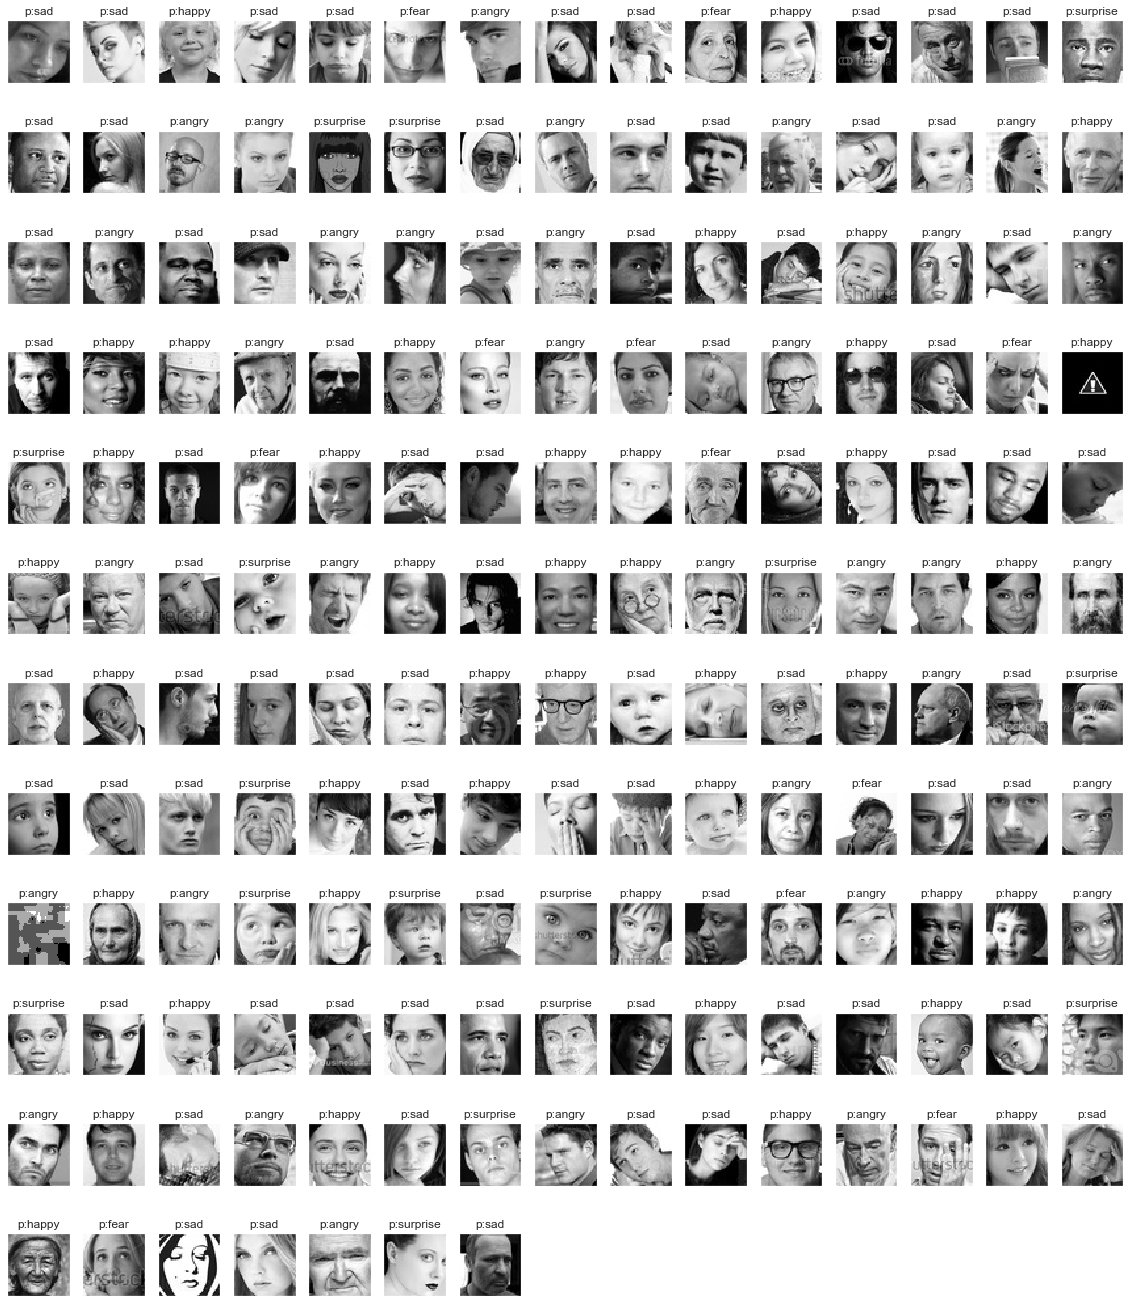

time: 17.7 s


In [52]:
plot_miss_classified(emotion="neutral")

total 174 miss labels out of 399 for emotion angry


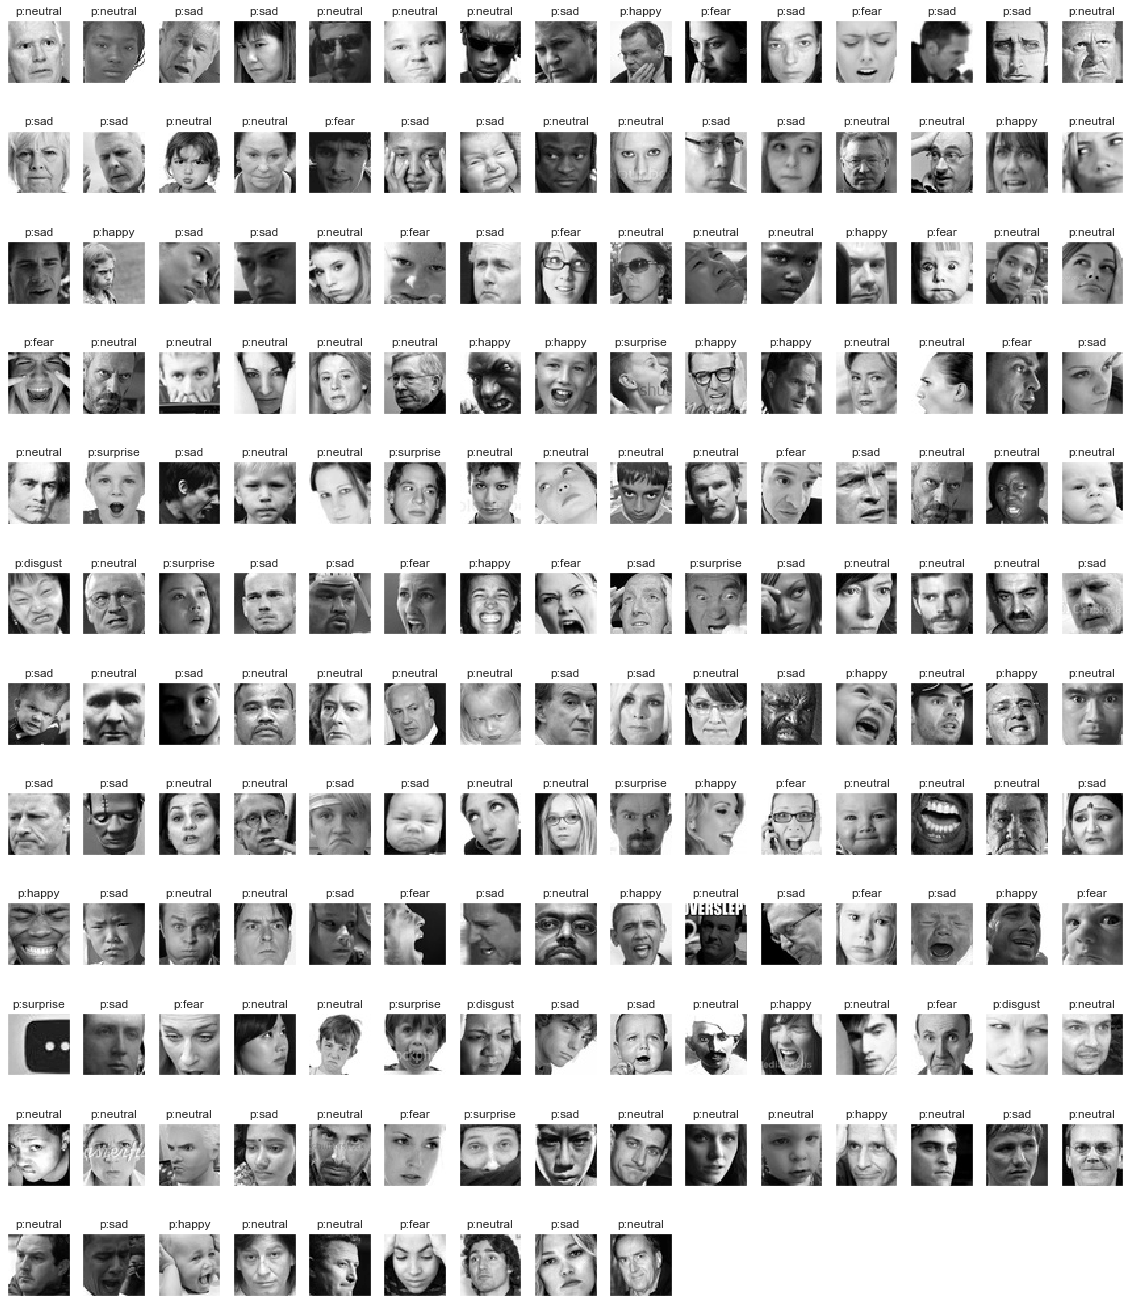

time: 16.7 s


In [53]:
plot_miss_classified(emotion="angry")

total 27 miss labels out of 44 for emotion disgust


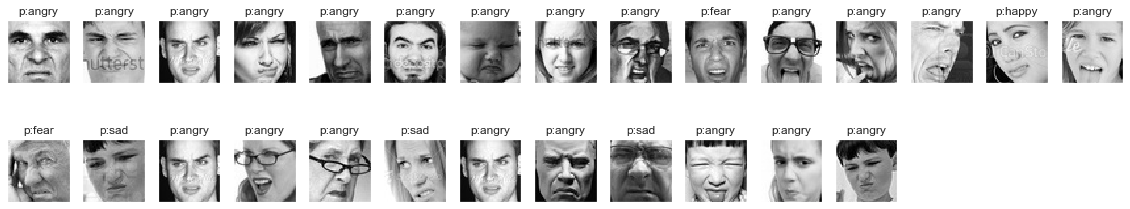

time: 2.43 s


In [54]:
plot_miss_classified(emotion="disgust")